### Import Modules 

In [1]:
import boto3
import spotipy
import spotipy.util as util
import os
from json.decoder import JSONDecodeError
import spotipy
import requests
from spotipy import util
import time
import spotipy
import spotipy.util as util
import matplotlib
from sklearn.manifold import TSNE
import spotipy
import spotipy.oauth2 as oauth2
import json
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from PIL import Image
import numpy as np
import boto3
import urllib
import json
from nltk.corpus import stopwords
import gensim
from pymongo import MongoClient
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from gensim.test.utils import datapath, get_tmpfile
import pickle
import scipy
import datetime
pd.set_option('display.max_columns', 500)

%matplotlib inline

### Phease 1: 
Take User input image and save it to S3

In [2]:
#Insert AWS Keys here. 
aws_access_key_id='private'
aws_secret_access_key='private'

s3 = boto3.resource(
    's3',
    region_name='us-east-2',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
)


In [3]:
# List Bucket Names
for bucket in s3.buckets.all():
    print(bucket.name)

bucketforpackages
cf-templates-mtre1eej2jle-us-east-1
cf-templates-mtre1eej2jle-us-east-2
deeplens-sagemaker-bba7d7fb-df61-439a-8f97-7d0332aec452
elasticbeanstalk-us-east-1-338531412026
elasticbeanstalk-us-east-2-338531412026
facialanalysistest
lkljll
metisvideo
mybucket-test-1
mybucket-test-2
trylast222
us-east-11


#### Declare Variable for Photo Name 
- Use Timestamp for uploaded image name

In [4]:
# photo_title='file03_test.jpg'
photo_title=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+'.jpg'
photo_title

'20180705_231531.jpg'

In [5]:
#Save Photo Locally. 
resource = urllib.request.urlopen("https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Ftravisbradberry%2Ffiles%2F2014%2F10%2FToxic_people1.jpg")
output = open(f"images/{photo_title}","wb")
output.write(resource.read())
output.close()

#### Upload Photo to S3

In [6]:
data = open(f'images/{photo_title}', 'rb')
s3.Bucket('facialanalysistest').put_object(Key=f'{photo_title}', Body=data, ACL='public-read')

s3.Object(bucket_name='facialanalysistest', key='20180705_231531.jpg')

#### Create a between S3 and AWS Rek Interface

In [7]:
photo=photo_title
bucket='facialanalysistest'
client=boto3.client('rekognition', region_name='us-east-2',    aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key,)

response = client.detect_faces(Image={'S3Object':{'Bucket':bucket,'Name':photo}},Attributes=['ALL'])

In [8]:
#Capture rekognition response: 
face_details_imported=response

###### Visualize Data Recieved from Rekognition interface

In [9]:
print(f'number of people: {len(response["FaceDetails"])}')  #number of peopple. 
response['FaceDetails'][0]['Emotions']  # Emotion of person

number of people: 2


[{'Confidence': 50.27027893066406, 'Type': 'HAPPY'},
 {'Confidence': 33.81645584106445, 'Type': 'SAD'},
 {'Confidence': 9.769832611083984, 'Type': 'CONFUSED'}]

### Phease 2: Save Image feature Data on MongoDB

In [10]:
client = MongoClient()
db = client.facial_features
db.collection_names()

['dict_collection']

#### Insert AWS Rek Dicto Into Mongo

In [11]:
db.dict_collection.insert({'id':photo_title, "details":face_details_imported})

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  """Entry point for launching an IPython kernel.


ObjectId('5b3eded736a8225e086bd49c')

#### Call Mongo Entry  (Finds the phto in the ID using the saved photo tag) 

In [12]:
#list all people from 1 photo
dict_imported_mongo=list(db.dict_collection.find({'id':photo_title}))[0]  #<-- 0 is eval and selects first of all duplicates. 
list(db.dict_collection.find({'id':photo_title}))[0]['details']['FaceDetails'][0]['Emotions'] #<-- 0 index the person. 

[{'Confidence': 50.27027893066406, 'Type': 'HAPPY'},
 {'Confidence': 33.81645584106445, 'Type': 'SAD'},
 {'Confidence': 9.769832611083984, 'Type': 'CONFUSED'}]

In [13]:
list(db.dict_collection.find({'id':photo_title}))[0] ['details']['FaceDetails'][0]['Emotions'] #<-- 0 index the person. 

[{'Confidence': 50.27027893066406, 'Type': 'HAPPY'},
 {'Confidence': 33.81645584106445, 'Type': 'SAD'},
 {'Confidence': 9.769832611083984, 'Type': 'CONFUSED'}]

#### Plot emotions onto the image
-Using Extract_Emotions Feature.
-Data is collected from Mongo

653 960


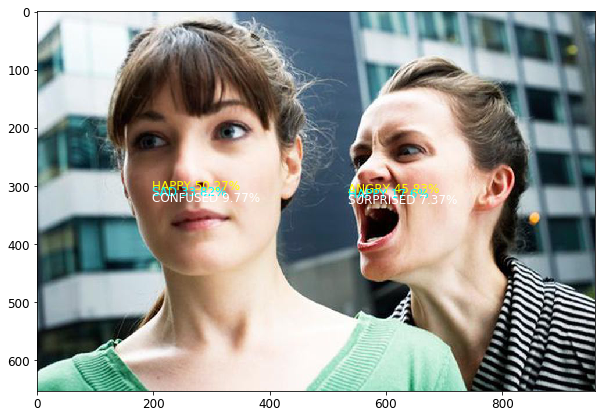

In [14]:
def extract_emotions(dict_mongo,photo):
    coords_x_m=[]
    coords_y_m=[]
    emotion_plot_v1_m=[]
    emotion_plot_v2_m=[]
    emotion_plot_v3_m=[]
    num_of_people_m=len(dict_mongo['details']['FaceDetails'])

    for i in range(num_of_people_m):
        coords_x_m.append((dict_mongo)['details']['FaceDetails'][i][ 'Landmarks'][3]['X'])
        coords_y_m.append((dict_mongo)['details']['FaceDetails'][i][ 'Landmarks'][3]['Y'])
        
        emotion_type_v1_m=(dict_mongo)['details']['FaceDetails'][i]['Emotions'][0]['Type']
        emotion_conf_v1_m=round((dict_mongo)['details']['FaceDetails'][i]['Emotions'][0]['Confidence'],2)
        emotion_v1_m=str(emotion_type_v1_m)+' '+str(emotion_conf_v1_m)+"%"
        emotion_plot_v1_m.append(emotion_v1_m)

        emotion_type_v2_m=(dict_mongo)['details']['FaceDetails'][i]['Emotions'][1]['Type']
        emotion_conf_v2_m=round(dict_mongo['details']['FaceDetails'][i]['Emotions'][1]['Confidence'],2)
        emotion_v2_m=str(emotion_type_v2_m)+' '+str(emotion_conf_v2_m)+"%"
        emotion_plot_v2_m.append(emotion_v2_m)

        emotion_type_v3_m=(dict_mongo)['details']['FaceDetails'][i]['Emotions'][2]['Type']
        emotion_conf_v3_m=round(dict_mongo['details']['FaceDetails'][i]['Emotions'][2]['Confidence'],2)
        emotion_v3_m=str(emotion_type_v3_m)+' '+str(emotion_conf_v3_m)+"%"
        emotion_plot_v3_m.append(emotion_v3_m)
        
    emotion_plot_v1_m=[w.replace('CALM', 'calm') for w in emotion_plot_v1_m]
    im = np.array(Image.open(f'images/{photo}'), dtype=np.uint8)
    len2=(im.shape[0])
    width2=im.shape[1]
    print(len2,width2)
    plt.rcParams.update({'font.size': 12})
    # Create figure and axes Adjust size all kinds
    fig,ax = plt.subplots(1,figsize=(10, 10))
    
    for i in range(num_of_people_m):
    # Create a Rectangle patch
        rect = patches.Rectangle((coords_x_m[i]*width2-width2,coords_y_m[i]*len2-len2*.06),50,50,linewidth=1,edgecolor='yellow',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(coords_x_m[i]*width2-width2*.03,coords_y_m[i]*len2-len2*.085, emotion_plot_v1_m[i],color='yellow')
        plt.text(coords_x_m[i]*width2-width2*.03,coords_y_m[i]*len2-len2*.070, emotion_plot_v2_m[i],color='cyan')
        plt.text(coords_x_m[i]*width2-width2*.03,coords_y_m[i]*len2-len2*.055, emotion_plot_v3_m[i],color='white')
    ax.imshow(im)
    
extract_emotions(dict_imported_mongo,photo_title)

### Phase 3: Average and Scale Emotions for a given Picture

In [15]:
client = MongoClient()
db = client.facial_features
db.collection_names()
dict_emotion_values_list_test=list(db.dict_collection.find({'id':photo_title}))[0]


##### Import Data from Mongo

In [16]:
dict_all_people_emo=[]
for i in range(len(dict_emotion_values_list_test['details']['FaceDetails'])):
    dict_all_people_emo.append(dict_emotion_values_list_test['details']['FaceDetails'][i]['Emotions'])
    
print(f'number of people: {len((dict_all_people_emo))}')

number of people: 2


#### Average emotion data for 8 Emotions

In [17]:
dict_emotion_values_v2={'happy':0, 'sad':0, 'angry':.0, 'confused':0, 'surprised':0, 'calm':0, 'unknown':0,'disgusted':0}

for j in (dict_all_people_emo):
    for i in range(len(j)):
        dict_emotion_values_v2[j[i]['Type'].lower()]+=j[i]['Confidence']
# dict_emotion_values_v2['happy']=dict_emotion_values_v2['happy']*.2
dict_emotion_values_v2.values()
dict_emotion_values_list=np.array(list(dict_emotion_values_v2.values())).reshape(-1,1)
pd.DataFrame(dict_emotion_values_list )

#Scale the appened dictionary. 
scaler=MinMaxScaler()
X_train_minmax = scaler.fit_transform(dict_emotion_values_list)
# X_train_minmax=[1-i for i in X_train_minmax]
print("Average Array for all emotions")
X_train_minmax

Average Array for all emotions


array([[ 1.        ],
       [ 0.49828211],
       [ 0.67530214],
       [ 0.14395751],
       [ 0.10858323],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

### Phase 4: Lyrics Analysis using Word2Vec 

In [18]:
# Import 1.2 Million words in 100D Vector Space
stoplist = stopwords.words('english')
glove_file2 = datapath('/home/ubuntu/downloads/glove/glove.twitter.27B.100d.txt')
tmp_file2 = get_tmpfile("glove_word2vec2.txt")
glove2word2vec(glove_file2, tmp_file2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/downloads/glove/glove.twitter.27B.100d.txt'

#### Create the Word2Vec Model
-Average Execute time (1Min)

In [19]:
model3 = KeyedVectors.load_word2vec_format(tmp_file2)

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/8h/953cg6bj5_z4y8jcw22mh2vc0000gn/T/glove_word2vec2.txt'

###### Test the word2vec model 

In [48]:
model3.similar_by_word('happy' , topn=5)

[('birthday', 0.9259342551231384),
 ('day', 0.8549739718437195),
 ('bday', 0.8145427703857422),
 ('merry', 0.7886534333229065),
 ('love', 0.7855905294418335)]

### Phase 5, Assign Song Distances to each Emotion using Word2Vec Model

In [49]:
mood_list=["HAPPY", "SAD", "ANGRY", "CONFUSED", "SURPRISED", "CALM", "UNKNOWN","DISGUSTED"]
mood_list_v2=[i.lower() for i in mood_list]

#### Import Scraped Songs (From a Pickle) - 
-Data Stored on a Public FTP Server / Hardcoded the link

In [49]:
import urllib.request
url2 = 'http://downloadforpc.net/Metis/facial_rec/df_export_final.pkl'
response2 = urllib.request.urlopen(url2)
response2

In [47]:
#Import Scraped Songs
# with open("Lyrics_Folder/df_export_final.pkl",'rb') as picklefile:
#     df3=pickle.load(picklefile)
# print(len((df3)))
# df3.head(1)

df3=pickle.load(response2)

##### Create song vectors for each song for each mood
- Use the function

In [60]:
def create_song_vector(song):
    """Returns list of moods in percent, an array of 8 items (values 0-1)"""
    list_of_words = str(song).split(" ")
    dim_array_28b = []
    list_mood = []
    list_mood_percent = []
    mood_list_v2 = [
        'happy', 'sad', 'angry', 'confused', 'surprised', 'calm', 'unknown',
        'disgusted']
    for i in range(len(list_of_words)):
        try:
            dim_array_28b.append(model3[list_of_words[i]])
        except:
            pass
    song_vector = (np.average(dim_array_28b, axis=0))
    for i in range(len(mood_list_v2)):
        mood_list_v2.append(mood_list_v2[i])
        list_mood_percent.append(
            scipy.spatial.distance.cosine(song_vector,
                                          model3[mood_list_v2[i]]))
    return list_mood_percent



def song_100D_vector(song):
    """Returns 100D Song Vector"""
    list_of_words = str(song).split(" ")
    dim_array_28b = []
    list_mood = []
    list_mood_percent = []
    mood_list_v2 = [
        'happy', 'sad', 'angry', 'confused', 'surprised', 'calm', 'unknown',
        'disgusted']
    for i in range(len(list_of_words)):
        try:
            dim_array_28b.append(model3[list_of_words[i]])
        except:
            pass
    song_vector = (np.average(dim_array_28b, axis=0))
    return song_vector

###### Test Create_song_vector

In [63]:
song_100D_vector(df3.lyrics[2])
str(df3.lyrics[2])
song_vector2=create_song_vector(df3.lyrics[0])
song_vector2

[0.3200199007987976,
 0.2563716173171997,
 0.36654365062713623,
 0.32330256700515747,
 0.2699214220046997,
 0.3210229277610779,
 0.5147216618061066,
 0.6552886366844177]

##### Use Apply the function to add new columns using the custom functions:
(1/2) Adding Distance column for each song and spread columns out for each word vector

Execute Time:5m 40s

In [24]:
dataframe_dist_added=df3.copy()
dataframe_dist_added.head(1)
dataframe_dist_added["dist_col"]=dataframe_dist_added.lyrics.apply(create_song_vector)
dataframe_dist_added["song_100D_vector"]=dataframe_dist_added.lyrics.apply(song_100D_vector)
dataframe_dist_added[mood_list_v2] = pd.DataFrame(dataframe_dist_added.dist_col.values.tolist(), index= dataframe_dist_added.index)
dataframe_dist_added

NameError: name 'df3' is not defined

#### Apply the function: add new column song feature distance.
(2/2) Adding song feature column for each song 

In [65]:
zip_values=list(zip(dataframe_dist_added['danceability'],dataframe_dist_added['acousticness'],dataframe_dist_added['energy']))

In [66]:
dataframe_dist_added['emotionmatrix']=zip_values
dataframe_dist_added['emotionmatrix']=dataframe_dist_added['emotionmatrix'].apply(list)
dataframe_dist_added.head(1)  # This object exists in pickle

,level_0,name,artist_x,album,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,primary_key,index,song,year,artist_y,genre,lyrics,tup_col,dist_col,song_100D_vector,happy,sad,angry,confused,surprised,calm,unknown,disgusted,emotionmatrix
0,0,all i could do was cry,beyonce knowles,Music From The Motion Picture Cadillac Records,False,0.372,0.488,9,-9.471,1,0.072,0.358,0.000706,0.104,0.5,185.262,audio_features,35g7hIs8Jf8tvXPRMSkNPC,spotify:track:35g7hIs8Jf8tvXPRMSkNPC,https://api.spotify.com/v1/tracks/35g7hIs8Jf8t...,https://api.spotify.com/v1/audio-analysis/35g7...,190400,3,"(beyonce knowles, all i could do was cry, 5)",5,all i could do was cry,2009,beyonce knowles,Pop,I heard Church bells ringing I heard A choir s...,"(beyonce knowles, all i could do was cry, 5)","[0.3200199007987976, 0.2563716173171997, 0.366...","[0.03022172, 0.25325352, 0.13928455, 0.0949978...",0.32002,0.256372,0.366544,0.323303,0.269921,0.321023,0.514722,0.655289,"[0.372, 0.358, 0.488]"


### Phase 4-5  (Import) 
-No need to run Phase 4-5, encompossed in file below: 
-Data Stored on a Public FTP Server / Hardcoded the link

In [20]:
import urllib.request
url = 'http://downloadforpc.net/Metis/facial_rec/df_export_TSNE.pkl'
response = urllib.request.urlopen(url)
response

In [21]:
dataframe_dist_added=pickle.load(response)

In [22]:
print(len(dataframe_dist_added.columns))
(len(dataframe_dist_added))

42


260806

#### Declare two additonal functions to calculate distance per song (X_train_minmax) input3(implicit)

In [27]:
def song_dist(dataframe_dist_added):
#     song_cosine=scipy.spatial.distance.cosine(dict_emotion_values_list, dataframe_dist_added)
    song_cosine=scipy.spatial.distance.cosine(X_train_minmax, dataframe_dist_added)
    
    return song_cosine
# scipy.spatial.distance.cosine(dict_emotion_values_list, dataframe_dist_added.dist_col[2323])


def feature_dist(dataframe_dist_added):
#     song_cosine=scipy.spatial.distance.cosine(dict_emotion_values_list, dataframe_dist_added)
    song_cosine=scipy.spatial.distance.cosine(X_train_minmax[0:3], dataframe_dist_added)
    
    return song_cosine


In [28]:
def remote_nulls(cell_dist_added):
    v=np.any(np.isnan(cell_dist_added))
    return (v)

dataframe_dist_added['nulls']=dataframe_dist_added.dist_col.apply(remote_nulls)

dataframe_dist_added=dataframe_dist_added[dataframe_dist_added.nulls==False]

In [29]:
dataframe_dist_added_v2=dataframe_dist_added.copy()
dataframe_dist_added_v2['word_vec_similarity']=dataframe_dist_added_v2.dist_col.apply(song_dist)
dataframe_dist_added_v2['emotionmatrix_dist']=dataframe_dist_added_v2.emotionmatrix.apply(feature_dist)
dataframe_dist_added_v2.head(1)
len(dataframe_dist_added_v2)

257633

### Phase 6:  Final Playlist for the User: 
This will be populated on the APP

low - word_vect_dist is good (close match)

low - emotionmatrix_dist is good (close match)

In [30]:
# final_playlist=dataframe_dist_added_v2[dataframe_dist_added_v2.artist_x=='diamond rio'].sort_values(by='word_vec_similarity').head(20)
final_playlist=dataframe_dist_added_v2.sort_values(by='word_vec_similarity').head(50)
final_playlist
final_playlist.sort_values(by='emotionmatrix_dist')

,level_0,name,artist_x,album,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,primary_key,index,song,year,artist_y,genre,lyrics,tup_col,dist_col,song_100D_vector,happy,sad,angry,confused,surprised,calm,unknown,disgusted,emotionmatrix,nulls,word_vec_similarity,emotionmatrix_dist
211444,85069,mahna mahna,cake,b-sides and rarities,False,0.7420,0.4830,7,-11.369,1,0.1550,0.213000,0.471000,0.0733,0.6380,89.883,audio_features,5FnyVsDPOblZ8gVvaXta9z,spotify:track:5FnyVsDPOblZ8gVvaXta9z,https://api.spotify.com/v1/tracks/5FnyVsDPOblZ...,https://api.spotify.com/v1/audio-analysis/5Fny...,174067,4,"(cake, mahna mahna, 282527)",282527,mahna mahna,2007,cake,Rock,Mahna mahna Mahna mahna Mahna mahna Mahna mahn...,"(cake, mahna mahna, 282527)","[1.21241267025, 1.1526248455, 1.11717186868, 1...","[-1.3778, -0.38422, -0.013582, 0.32273, -1.160...",1.212413,1.152625,1.117172,1.173088,1.042843,1.298281,0.968886,1.031091,"[0.742, 0.213, 0.483]",False,0.329150,0.012197
78223,78223,open,com truise,In Decay,False,0.4060,0.4480,3,-11.615,1,0.0493,0.288000,0.623000,0.3490,0.1720,86.855,audio_features,5gMA7DviFvmEpFVLkoMCbS,spotify:track:5gMA7DviFvmEpFVLkoMCbS,https://api.spotify.com/v1/tracks/5gMA7DviFvmE...,https://api.spotify.com/v1/audio-analysis/5gMA...,252000,4,"(com truise, open, 122957)",122957,open,2012,com truise,Pop,Robotic Voice District Mainframe Laser C...,"(com truise, open, 122957)","[1.09829292446, 1.04015255719, 0.999306192098,...","[0.0091955, -0.61429, -0.4535, -0.55526, 0.301...",1.098293,1.040153,0.999306,0.945398,0.945732,1.001500,0.771421,0.993893,"[0.406, 0.288, 0.448]",False,0.306355,0.025433
257382,131007,no exit,fates warning,No Exit,False,0.1660,0.1110,1,-19.607,0,0.0343,0.143000,0.000030,0.0746,0.0574,142.183,audio_features,4f2iWltqZPe4p2GjjgS0Mw,spotify:track:4f2iWltqZPe4p2GjjgS0Mw,https://api.spotify.com/v1/tracks/4f2iWltqZPe4...,https://api.spotify.com/v1/audio-analysis/4f2i...,41440,4,"(fates warning, no exit, 356564)",356564,no exit,2007,fates warning,Rock,Under brooding skys and watchful eyes On convu...,"(fates warning, no exit, 356564)","[0.547093808651, 0.404066324234, 0.41873657703...","[-0.32377, 0.0129174, 0.0714557, 0.472571, 0.0...",0.547094,0.404066,0.418737,0.374631,0.417230,0.369688,0.461061,0.610615,"[0.166, 0.143, 0.111]",False,0.337122,0.026304
259038,132663,tukuza,gloria muliro,Sitolia,False,0.6700,0.8220,9,-6.570,1,0.2830,0.499000,0.000000,0.0615,0.7070,119.832,audio_features,1UMeBA2vzglXVBuNAsyGhR,spotify:track:1UMeBA2vzglXVBuNAsyGhR,https://api.spotify.com/v1/tracks/1UMeBA2vzglX...,https://api.spotify.com/v1/audio-analysis/1UMe...,307018,4,"(gloria muliro, tukuza, 359306)",359306,tukuza,2013,gloria muliro,Not Available,VERSE LYRICS Nitamtukuza Mwokozi milele dai...,"(gloria muliro, tukuza, 359306)","[1.10724766552, 0.987764075398, 1.06272377074,...","[0.188069, -0.287718, -0.162289, -0.105407, -0...",1.107248,0.987764,1.062724,1.026558,1.051100,0.989925,0.908448,1.089049,"[0.67, 0.499, 0.822]",False,0.328028,0.036796
181998,55623,nukuttaja,apulanta,Viivakoodit,False,0.4830,0.6180,4,-17.583,0,0.0742,0.456000,0.786000,0.2530,0.1660,134.340,audio_features,0J1ja0yT61EP8GbATPs7BK,spotify:track:0J1ja0yT61EP8GbATPs7BK,https://api.spotify.com/v1/tracks/0J1ja0yT61EP...,https://api.spotify.com/v1/audio-analysis/0J1j...,352293,4,"(apulanta, nukuttaja, 235767)",235767,nukuttaja,2007,apulanta,Rock,Enkeli sinun kanssasi min tahtoisin jakaa elmn...,"(apulanta, nukuttaja, 235767)","[1.1701579392, 0.979376899078, 1.10522405803, ...","[0.0969851, -0.230139, 0.149661, -0.434197, 0....",1.170158,0.979377,1.105224,0.987243,1.093942,1.007400,1.034361,0.972407,"[0.483, 0.456, 0.618]",False,0.316336,0.048032
121924,121924,the debt collector,blur,Parklife,False,0.3630,0.3910,4,-11.884,1,0.0322,0.076000,0.282000,0.4830,0.5670,186.628,audio_features,6dtoq7izygFBc8pYOCoCMi,spotify:track:6dtoq7izygFBc8pYOCo

### Phase 6: Plot the TSNY!

In [31]:
import re
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt

# Function for TSNY, Get a sample from a large Dataset
def create_array_sample(arr,sample_len):
    """NumPy does not have a default random sample function, so I've created one here"""
    origLen = len(arr)
    newArr = np.random.choice(range(origLen), sample_len, replace=False)       
    return arr[newArr]

In [32]:
dataframe_dist_added.columns
df_tsny=dataframe_dist_added[['happy', 'sad', 'surprised','calm']]
df_tsny_v2=df_tsny.dropna()
values_col=df_tsny_v2.columns
values_col
emotion_array=np.array(df_tsny_v2[['happy', 'sad', 'surprised','calm']])
emotion_array_token_sample = create_array_sample(emotion_array,2000)  #Declare the number of points on TSNE Plot
len(emotion_array_token_sample)


# Removes any null values in the dataset. 
token_emotion=[]
for i in emotion_array_token_sample:
    try:
        token_emotion.append(i.astype('Float64'))
    except:
        pass
len(token_emotion)

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  from ipykernel import kernelapp as app


2000

### Create the TSNY Values

In [33]:
new_values = TSNE(metric='cosine',verbose=2).fit_transform(token_emotion)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000219
[t-SNE] Computed conditional probabilities in 0.096s
[t-SNE] Iteration 50: error = 83.3130264, gradient norm = 0.0419989 (50 iterations in 2.326s)
[t-SNE] Iteration 100: error = 82.0621338, gradient norm = 0.0494712 (50 iterations in 2.449s)
[t-SNE] Iteration 150: error = 82.4676208, gradient norm = 0.0564354 (50 iterations in 2.332s)
[t-SNE] Iteration 200: error = 84.5989609, gradient norm = 0.0446847 (50 iterations in 2.219s)
[t-SNE] Iteration 250: error = 83.4020538, gradient norm = 0.1293579 (50 iterations in 2.139s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.402054
[t-SNE] Iteration 300: error = 2.5807161, gradient norm = 0.0042343 (50 iterations in 2.337s)

### Plot the TSNE

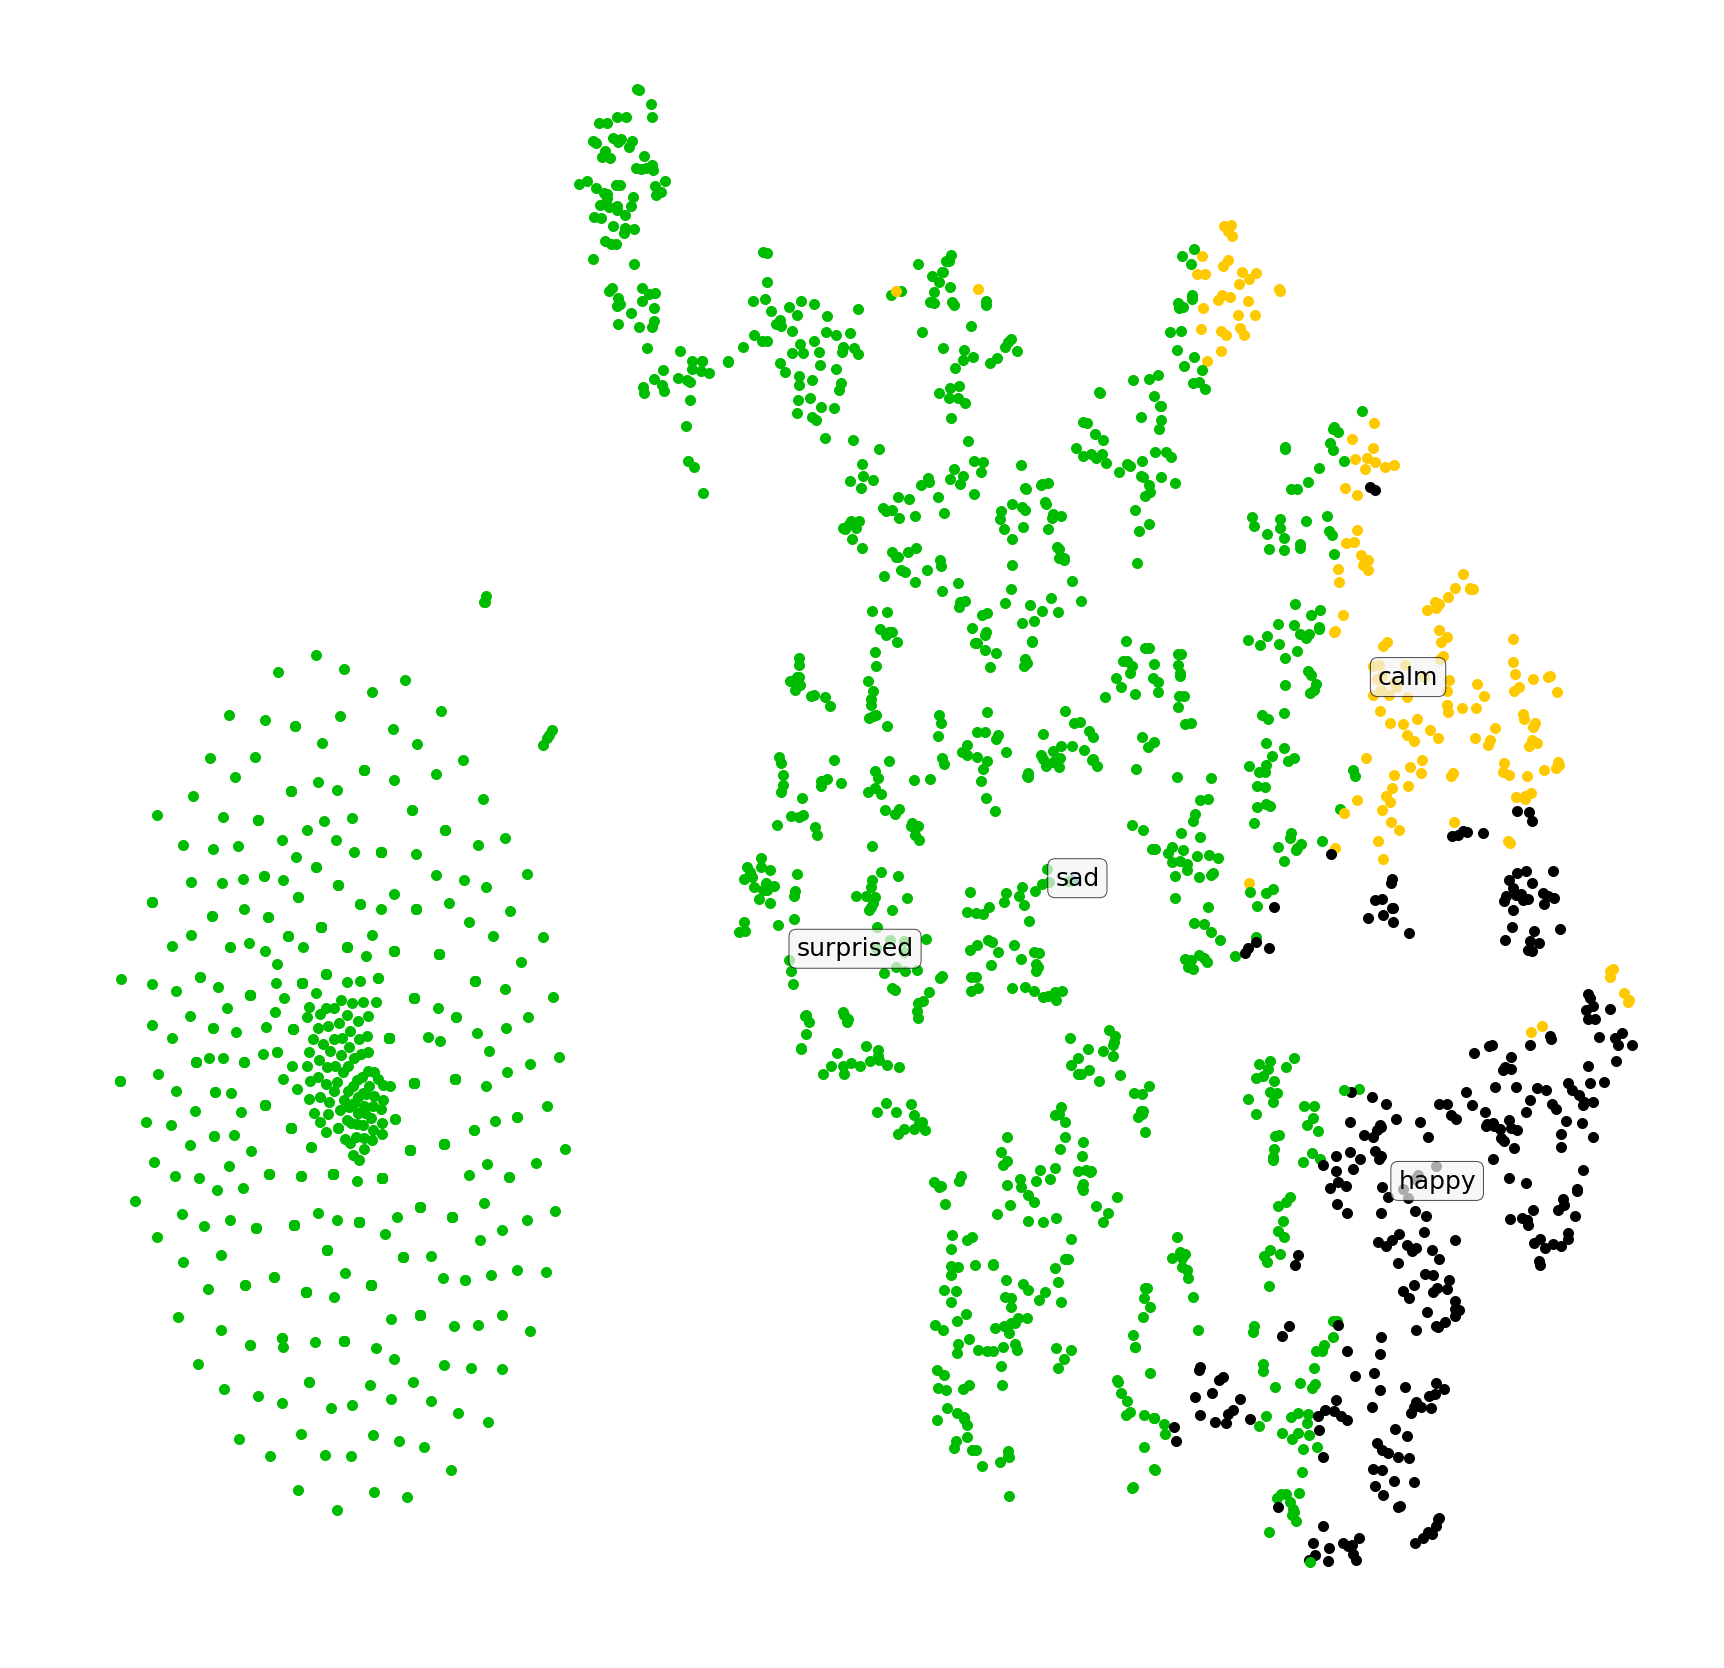

In [34]:
x = []
y = []
labels = []
topics=values_col   # DECLARE THE LABELS THAT YOU WOULD LIKE ON THE PLOT. 
num_topics = len(token_emotion[0])  # new vector called topics with actual topics or emotions used
for value in new_values:
    x.append(value[0])
    y.append(value[1])

cmap = matplotlib.cm.get_cmap('nipy_spectral')
cmapScale = int(cmap.N / num_topics)
plt.figure(figsize=(30, 30),facecolor='white')
labels = [] 
for i in range(len(x)):
    label = np.argmax(token_emotion[i])
    labels.append(label)
    plt.scatter(x[i],y[i], c=cmap(label*cmapScale),s=100)

color_legend = []
for i in range(num_topics):
    boolArr = np.array(labels) == i
    x_avg = np.median(np.array(x)[boolArr])
    y_avg = np.median(np.array(y)[boolArr])
    plt.annotate(topics[i],
                 xy=(x_avg, y_avg),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='center',
                 va='center',
                 fontsize=25,
                 bbox=dict(boxstyle="round", fc="whitesmoke",alpha=0.7))

plt.axis('off')
plt.show()